In [1]:
import pandas as pd
import numpy as np
import math
import random
import copy
import matplotlib.pyplot as plt

In [2]:
songs = pd.read_csv('spotify_songs.csv')

In [3]:
songs.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [4]:
songs.columns
# onee-hot encode: playlist_genre, playlist_subgenre, key

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

# Build a NN
### What are the drivers of popularity
What makes a song popular? I will build a Neural Network to model the popularity (as measured by Spotify). Once I built the model, I will try to interpret it - what is it that creates high popularity?


#### Steps to take
1. Select input variables
1. one-hot encode inputs if necessary
1. Normalize Data
1. Build NN
    1. def initialize params
    1. def forward prop
    1. def compute cost
    1. def backward prop
    1. def update params
1. Hyperparameter Tuning & Optimization - find the best / a good model
1. Interpretation
1. Where are my songs on the scale / in this spectrum?

### ONE HOT ENCODE

In [5]:
# ONE HOT ENCODE
songs['key'] = songs['key'].astype(str) # make key a categorical variable
songs_onehot = pd.get_dummies(songs, columns = ['playlist_genre', 'playlist_subgenre', 'key'])

### SELECT INPUT VARS

In [6]:
# SELECT INPUT VARS
X = songs_onehot.drop(['track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id'], axis=1)
Y = songs_onehot[['track_popularity']]


### NORMALIZE DATA

In [7]:
# NORMALIZE DATA

def normalize_columns(data, columns):
    
    df = data.copy()
    
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    
    return df

In [8]:
X.columns

Index(['danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_genre_edm', 'playlist_genre_latin',
       'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap',
       'playlist_genre_rock', 'playlist_subgenre_album rock',
       'playlist_subgenre_big room', 'playlist_subgenre_classic rock',
       'playlist_subgenre_dance pop', 'playlist_subgenre_electro house',
       'playlist_subgenre_electropop', 'playlist_subgenre_gangster rap',
       'playlist_subgenre_hard rock', 'playlist_subgenre_hip hop',
       'playlist_subgenre_hip pop', 'playlist_subgenre_indie poptimism',
       'playlist_subgenre_latin hip hop', 'playlist_subgenre_latin pop',
       'playlist_subgenre_neo soul', 'playlist_subgenre_new jack swing',
       'playlist_subgenre_permanent wave', 'playlist_subgenre_pop edm',
       'playlist_subgenre_post-teen pop',
       'playlist_subgenre_progressive

In [9]:
X_normal = normalize_columns(X, ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',])


In [10]:
# DIVIDE SAMPLE INTO TRAIN_DEV_TEST SET
m = len(Y)
train_size = math.floor(m * 0.9)
dev_size = math.floor(m * 0.05)
test_size = dev_size

X_train = X_normal[: train_size].T
X_dev = X_normal[train_size : train_size + dev_size].T
X_test = X_normal[train_size + dev_size:].T

Y_train = Y[: train_size].T / 100
Y_dev = Y[train_size : train_size + dev_size].T / 100
Y_test = Y[train_size + dev_size:].T / 100

### BUILD NN FRAMEWORK

In [11]:
def initialize_params(layer_dims):
    
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l-1], layer_dims[l]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [12]:
# initialiaze params
# forward prop
# compute costs
# backward prop
# update params

In [13]:
def sigmoid(x):
    x = np.array(x)
    s = 1 / (1 + np.exp(-x))
    return s

In [26]:
def forward_propagation_step(A_prev, W, b, activation):
    
    Z = np.dot(W.T, A_prev) + b    
    
    if activation == 'sigmoid':
        A_next = sigmoid(Z)
    
    cache = {'A_prev' : A_prev, 
             'Z' : Z,
             'W' : W, 
             'b' : b}
    
    return A_next, cache
    

In [36]:
def L_layer_forward_prop(X, params):
    
    caches = []
    L = len(params) // 2
    A = X.astype(np.float64).to_numpy()
    
    for l in range(1, L+1):
        A_prev = A
        
        W = params['W' + str(l)]
        b = params['b' + str(l)]
        
        A, cache = forward_propagation_step(A_prev, W, b, 'sigmoid')
        
        caches.append(cache)
    
    AL = A
    
    return AL, caches

In [28]:
def compute_cost(A, Y):
    
    Y = Y.to_numpy()
    m = Y.shape[1]
    
    cost = np.sum((Y-A)**2) / m
    
    return cost

In [29]:
def sigmoid_derivative(x):
    deriv = np.exp(-x) / (1 + np.exp(-x))**2
    return deriv

In [30]:
def backward_prop(AL, Y, caches):
    
    L = len(caches)
    m = Y.shape[1]
    Y = Y.to_numpy()
    
    # 1 - compute dAL
    dAL = -2 * (Y - AL) / m
    
    dA = dAL
    #print(dA)
    grads = {}
    
    for l in reversed(range(L)):
        
        Z = caches[l]['Z']
        A_prev = caches[l]['A_prev']
        W = caches[l]['W']
        
        dZ = sigmoid_derivative(Z) * dA
        dW = np.dot(A_prev, dZ.T) / m
        # print('Z/', Z)
        # print(dA)
        # print('DZ/', dZ)
        db = np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W, dZ)
        
        grads['dW' + str(l+1)] = dW
        grads['db' + str(l+1)] = db
        grads['dA' + str(l)] = dA
        
    
    return grads

In [31]:
def update_params(grads, params, learning_rate):
    
    L = len(params) // 2
    
    parameters = copy.deepcopy(params)
    
    for l in range(L):
        W = parameters['W' + str(l + 1)]
        b = parameters['b' + str(l + 1)]
        dW = grads['dW' + str(l + 1)]
        db = grads['db' + str(l + 1)]
        
        W = W - learning_rate * dW
        b = b - learning_rate * db
        
        parameters['W' + str(l + 1)] = W
        parameters['b' + str(l + 1)] = b
        
    return parameters

In [32]:
def model(X, Y, layer_dims, learning_rate = 0.01, activation = 'sigmoid', num_iter = 1000, print_cost = True):
    
    params = initialize_params(layer_dims)
    
    J = []
    
    for i in range(num_iter):
    
        AL, caches = L_layer_forward_prop(X, params)
        #print(AL, caches)
    
        cost = compute_cost(AL, Y)
        J.append(cost)
        #print(cost)
        
        grads = backward_prop(AL, Y, caches)
        #print(grads)
        
        params = update_params(grads, params, learning_rate)
        #print(params)
        
        #if i % 100 == 0:
         #   print(f'cost after {i} iterations: {J[i]}')
        
    return params, J

### Run NN

In [50]:
params, J = model(X_train, Y_train, layer_dims = [53,10,5,3,1], learning_rate = 0.01, print_cost = False, num_iter = 2000)

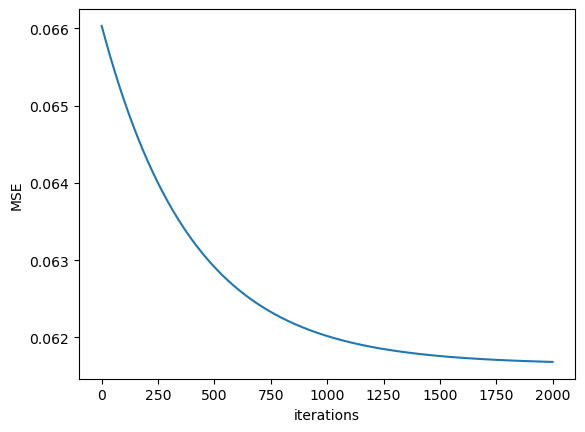

In [51]:
plt.plot(J);
plt.xlabel('iterations');
plt.ylabel('MSE');

### Evaluate the model on the dev set

Input dev set X to the model and compare it against actual corresponding Y 

In [52]:
L_layer_forward_prop(X_dev, params)

(array([[0.43816677, 0.43816677, 0.43816677, ..., 0.43816677, 0.43816677,
         0.43816677]]),
 [{'A_prev': array([[ 0.05617715,  0.24916704,  1.0142341 , ...,  1.02801909,
           -0.07478028, -0.57793249],
          [ 0.56039307,  0.30612304,  0.43878566, ...,  1.19606815,
            0.11818432,  1.58852841],
          [ 0.41141887,  0.28325821,  0.26418469, ..., -0.61185872,
           -0.97559409,  0.38397978],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]]),
   'Z': array([[-0.05146279, -0.02899062, -0.02934858, ..., -0.06314296,
            0.02295054,  0.04750262],
          [-0.02082114,  0.01813926,  0.0400727 , ...,  0.02778788,
            0.04360782,  0.05275963],
          [-0.02408575

In [49]:
Y_train.mean().mean()

0.4325087143388947

#### UNDERFITTING!! Model predictions for X_dev converge towards the mean of Y_train